In [94]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from gensim.utils import simple_preprocess
from collections import Counter
import re
import matplotlib.pyplot as plt

%matplotlib inline

In [43]:
def get_recap(game_id):
    response=requests.get(url= "http://www.espn.com/nhl/recap?gameId={}".format(game_id))
    html=BeautifulSoup(response.content, "lxml")
    teams=html.find_all('span', class_ = "teamshortname")
    teams=[t.string.strip() for t in teams]
    [h.extract() for h in html.find_all(['span','a'])]
    recap=html.find_all('p', class_ = None)
    return {'game_id':game_id,
            'team1':teams[0],
            'team2':teams[1],
            'recap':'\n'.join([p.string for p in recap if p.string])}

https://www.hockey-reference.com/friv/current_nhl_salaries.cgi

In [104]:
recaps_df=pd.DataFrame([get_recap(i) for i in range(400961606, 400962651)])  ## 400962874
recaps_df.head()

,game_id,recap,team1,team2
0,400961650,"""That's usually where I end up being and where...",PIT,WSH
1,400961651,Doesn't really matter which part -- a first go...,BOS,COL
2,400961652,"""We're going to have to find another formula a...",NYI,ANA
3,400961653,His new teenage teammate played a major role i...,CGY,LA
4,400961654,Barry Melrose believes Pittsburgh and Tampa Ba...,PIT,TB


In [196]:
players=pd.read_csv('Documents/salaries/salaries.csv')
players['first_name']=[name.split(' ')[0] for name in players.Player]
players['last_name']=[name.split(' ')[1] for name in players.Player]

goalies=set(pd.read_csv('Documents/salaries/goalies.csv').Player)
players['col']=['red' if name in goalies else 'blue' for name in players.Player]

rookies=pd.read_csv('Documents/salaries/Rookies.csv')
rookies=set([x.split(',')[0] for x in rookies.PLAYER])
for i,row in players.iterrows():
    if row['Player'] in rookies:
        players.set_value(i, 'col', 'green')

players.head()

,Player,Tm,Salary,Cap Hit,first_name,last_name,col
0,Jonathan Toews,CHI,13800000,10500000,Jonathan,Toews,blue
1,Patrick Kane,CHI,13800000,10500000,Patrick,Kane,blue
2,Anze Kopitar,LA,13000000,10000000,Anze,Kopitar,blue
3,Jamie Benn,DAL,13000000,9500000,Jamie,Benn,blue
4,Shea Weber,MTL,12000000,7857143,Shea,Weber,blue


In [143]:
def get_mentions(first_name,last_name,team):
    count=0
    for i,row in recaps_df.iterrows():
        if team in [row['team1'],row['team2']]:
            count+=len(re.findall("(\\b{}\\b|\\b{}\\b|\\b{}\\b)".format(first_name+' '+last_name, first_name, last_name),row['recap']))
    return count

In [197]:
all_recaps='\n'.join(recaps_df.recap)

for i,row in players.iterrows():
    count=get_mentions(row['first_name'], row['last_name'], row['Tm'])
    players.set_value(i, 'mentions', count)
    
players.head()

,Player,Tm,Salary,Cap Hit,first_name,last_name,col,mentions
0,Jonathan Toews,CHI,13800000,10500000,Jonathan,Toews,blue,25.0
1,Patrick Kane,CHI,13800000,10500000,Patrick,Kane,blue,44.0
2,Anze Kopitar,LA,13000000,10000000,Anze,Kopitar,blue,39.0
3,Jamie Benn,DAL,13000000,9500000,Jamie,Benn,blue,38.0
4,Shea Weber,MTL,12000000,7857143,Shea,Weber,blue,10.0


In [171]:
import plotly.offline as py
import plotly.graph_objs as go

# Create a trace
trace = go.Scatter(
    x = players.Salary,
    y = players.mentions,
    mode = 'markers',
    marker = {'color':players.col}
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data)

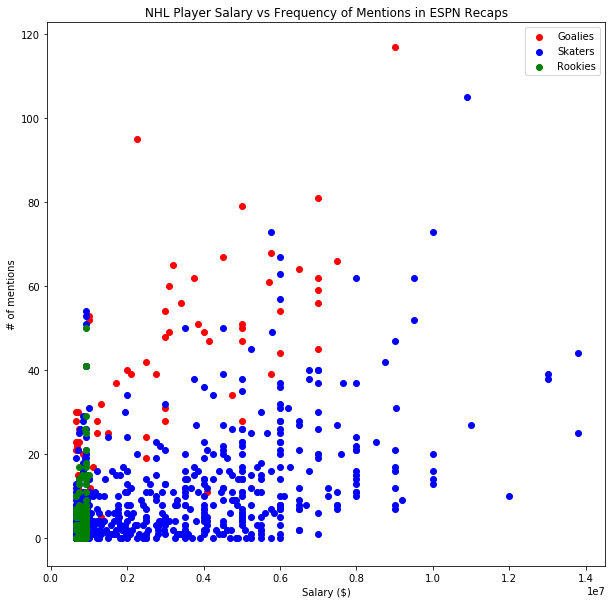

In [198]:
plt.subplots(figsize=(10,10))
temp=players.query('col == "red"')
p1=plt.scatter(temp.Salary, temp.mentions, c='red')
temp=players.query('col == "blue"')
p2=plt.scatter(temp.Salary, temp.mentions, c='blue')
temp=players.query('col == "green"')
p3=plt.scatter(temp.Salary, temp.mentions, c='green')
plt.legend([p1,p2,p3],('Goalies','Skaters','Rookies'))
plt.title('NHL Player Salary vs Frequency of Mentions in ESPN Recaps')
plt.xlabel('Salary ($)')
plt.ylabel('# of mentions')

plt.savefig('salary-mentions')
plt.show()